In [35]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVR
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date']).sort_index()
df = df[['Close']]
df.head(5)

,Close
Date,
1990-01-01,329.079987
1990-02-01,331.890015
1990-03-01,339.940002
1990-04-01,330.799988
1990-05-01,361.230011


In [7]:
df.sort_index(inplace=True)
temp = df.copy(deep=True)
temp['Close_1'] = df['Close']
temp['Close_2'] = df['Close'].shift(-1)
temp['Close_3'] = df['Close'].shift(-2)
temp['Close'] = temp['Close'].shift(-3)
temp.dropna(inplace=True)
print(len(temp))
temp.head(5)

410


,Close,Close_1,Close_2,Close_3
Date,,,,
1990-01-01,330.799988,329.079987,331.890015,339.940002
1990-02-01,361.230011,331.890015,339.940002,330.799988
1990-03-01,358.019989,339.940002,330.799988,361.230011
1990-04-01,356.149994,330.799988,361.230011,358.019989
1990-05-01,322.559998,361.230011,358.019989,356.149994


In [8]:
from sklearn.model_selection import train_test_split
X = temp[['Close_1','Close_2','Close_3']]
y = temp[['Close']]

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X[:320]
y_train = y[:320]
X_test = X[320:]
y_test = y[320:]

In [21]:
model = LinearSVR(epsilon=0.0, tol=0.0001, C=1.0, max_iter=1000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

C:\Users\shami\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shami\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\shami\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
x = []
for i in range(82):
    x.append(i)

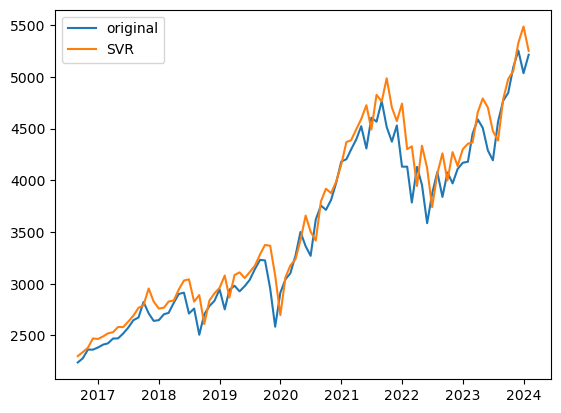

In [24]:
plt.plot(temp.index[320:],y_test,label='original')
plt.plot(temp.index[320:],predictions,label='SVR')
plt.legend()

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

error = mean_squared_error(y_test, predictions)
print('Mean Squared Error: %.3f' % error)
error2 = smape_kun(y_test.values, predictions)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error2)
error3=mean_absolute_percentage_error(y_test.values, predictions)
print('Mean Absolute Percenatage Error:%.3f' %error3)
R2Score= r2_score(y_test.values, predictions)
print('R2-Score:%.3f'% R2Score)

Mean Squared Error: 45977.855
Symmetric Mean Absolute Percentage Error: 27.159
Mean Absolute Percenatage Error:29.558
R2-Score:0.934


In [29]:
temp_svr = pd.DataFrame({'Timestamp': temp[320:].index, 'Predicted': predictions})
temp_svr.head(5)

,Timestamp,Predicted
0,2016-09-01,2300.601904
1,2016-10-01,2338.318931
2,2016-11-01,2381.046413
3,2016-12-01,2470.896888
4,2017-01-01,2466.236252


In [36]:
history = [predictions[-3],predictions[-2],predictions[-1]]
new = []
for i in range(36):
    pred = model.predict([history])[0]
    history.append(pred)
    history.pop(0)
    new.append(pred)

In [38]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

start_date = datetime(2024, 6, 1)
end_date = start_date + relativedelta(months=+36)
monthly_dates = [start_date + relativedelta(months=+i) for i in range(0, 36)]
final = []
for date in monthly_dates:
    final.append(date.strftime('%Y-%m-%d'))
    
further_svr = pd.DataFrame({'Timestamp': final, 'Predicted': new})
further_svr.tail(5)

,Timestamp,Predicted
31,2027-01-01,21380.152049
32,2027-02-01,22338.888863
33,2027-03-01,23340.608602
34,2027-04-01,24387.238312
35,2027-05-01,25480.791438


In [40]:
import sqlite3
result = pd.concat([temp_svr,further_svr])
result['Timestamp'] = pd.to_datetime(result['Timestamp'])
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
result.to_sql('svr_Prediction', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

In [ ]:
with open('svr.pkl', 'wb') as file:
    pickle.dump(svr, file)

In [41]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Execute a query to get the names of all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all rows from the result set
tables = cursor.fetchall()

# Extract table names from the result set
table_names = [table[0] for table in tables]

# Print the names of all tables
print("Tables in the database:")
for table_name in table_names:
    print(table_name)

# Close the cursor and connection
cursor.close()
conn.close()

Tables in the database:
Training
Testing
Arima_Prediction
Sarima_Prediction
ANN_Prediction
LSTM_Prediction
ETS_Prediction
Prophet_Prediction
svr_Prediction
